In [1]:
%matplotlib inline

In [2]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import numpy as np

import cv2
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.rcParams['figure.figsize'] = [18, 14]

/home/seanlolwut/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1. Support Vector Machine

## 1.1 Feature Extraction: choosing data representation of input images

## 1.1.1 Use Color Histogram to represent input images

In [3]:
# Load the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_test2 = x_test
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# check the shape of the training and testing data 
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


### An example of color histogram:

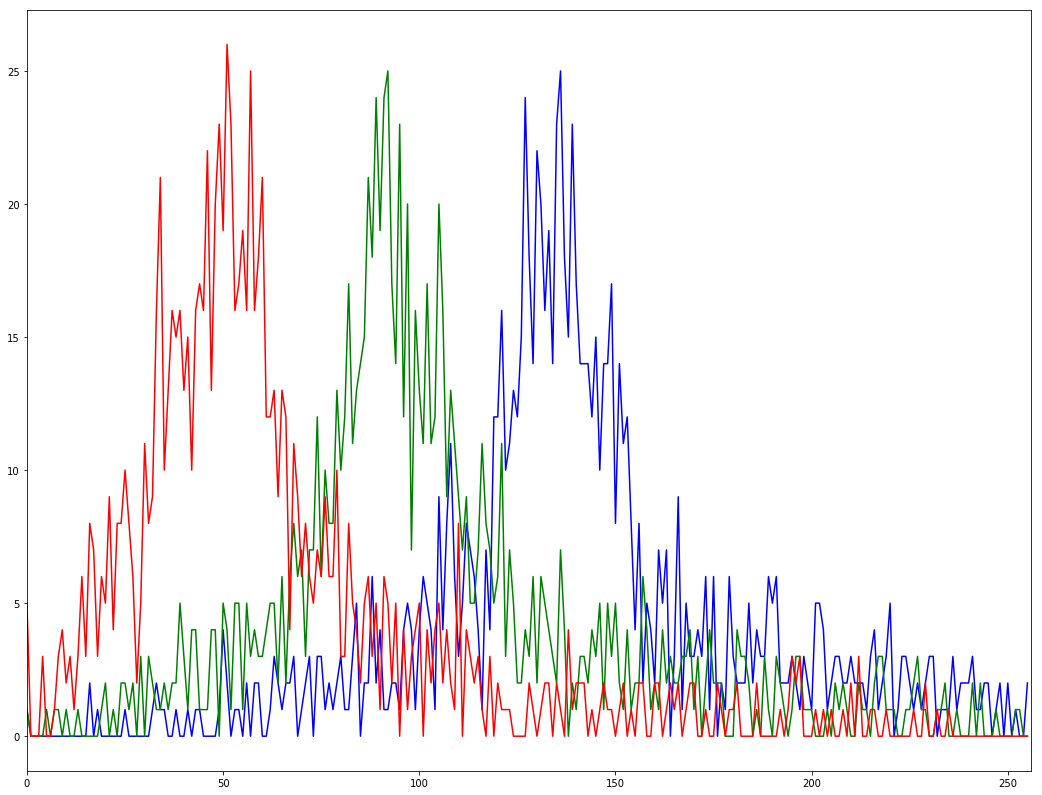

In [4]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
img = x_train[0]
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

### Transform the data into color histogram representation:

In [5]:
# define a function to turn an image to a color histogram representation
def color_hist_extract(img):
    color = ('b','g','r')
    col_hist=dict()
    for i,col in enumerate(color):
        col_hist[col] = cv2.calcHist([img],[i],None,[256],[0,256]).ravel()
    col_histogram = np.append(col_hist['b'], col_hist['g'])
    col_histogram = np.append(col_histogram, col_hist['r'])
    return col_histogram

In [6]:
x_train = np.array([color_hist_extract(x_train[i]) for i in range(x_train.shape[0])]) 
x_test = np.array([color_hist_extract(x_test[i]) for i in range(x_test.shape[0])]) 

In [7]:
print(x_train.shape, x_test.shape)

(50000, 768) (10000, 768)


In [8]:
# change the shape of the array
y_train = y_train.ravel()
y_test = y_test.ravel()

### Build linear SVM classifier and score the performance:

In [9]:
from sklearn.svm import LinearSVC
svm_linear = LinearSVC()
%time svm_linear.fit(x_train, y_train)
mean_acc = svm_linear.score(x_test, y_test)
print(mean_acc)

CPU times: user 9min 8s, sys: 124 ms, total: 9min 8s
Wall time: 9min 8s
0.174


### Recorded perfomance result:
#### CPU times: user 15min 4s, sys: 3.52 s, total: 15min 8s; Wall time: 15min 13s
#### mean_acc: 0.1428

## 1.1.2 Use Histogram of Oriented Gradient (HOG) to represent the input images
We will extract the Histogram of Oriented Gradient (HOG) features from the images (for each channel). HOGs is a commonly used feature descriptor in the field of computer vision which can be extracted and used in both supervised and unsupervised learning tasks. Feature descriptors such as HOG were the main approach undertaken in the field of Computer Vision before the rise of Convolutional Neural Networks with AlexNet in 2012. Despite performing severely weaker on supervised learning tasks, feature descriptors are still especially important in the field of computer vision, especially for unsupervised feature learning tasks such as Image Retrieval (given an image with unknown label, search a database of images that are similar to it) or image anomaly detection (given an image, determine if it is a distractor image, i.e. different from the rest of the dataset).

In [10]:
# reload the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [11]:
#HOG descriptor Configs
normalize = True                                     
block_norm = 'L2-Hys'     
orientations = 9          
pixels_per_cell = [8, 8]  
cells_per_block = [2, 2]  

def extractFeature(img, vis=False):
    return hog(img, orientations, pixels_per_cell, cells_per_block, block_norm, visualise=vis, transform_sqrt=normalize)

In [12]:
n_train = len(x_train)
n_test = len(x_test)
X_trainfeat = np.array([extractFeature(x_train[i,:,:,j], vis=False) for i in range(n_train) for j in range(3)])

/home/seanlolwut/anaconda3/envs/fastai/lib/python3.6/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


In [13]:
X = np.split(X_trainfeat, n_train)
X_Train = [np.hstack(X[i]) for i in range(len(X))]

X_Train = np.array(X_Train)
X_Train.shape

X_testfeat = np.array([extractFeature(x_test[i,:,:,j], vis=False) for i in range(n_test) for j in range(3)])

Xte = np.split(X_testfeat, n_test)
X_Test = [np.hstack(Xte[i]) for i in range(len(Xte))]

X_Test = np.array(X_Test)
X_Test.shape

/home/seanlolwut/anaconda3/envs/fastai/lib/python3.6/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


(10000, 972)

In [14]:
y_train = y_train.ravel()
y_test = y_test.ravel()
print(y_train.shape, y_test.shape)

(50000,) (10000,)


In [15]:
from sklearn.svm import LinearSVC
svm_linear = LinearSVC()
%time svm_linear.fit(X_Train, y_train)
mean_acc = svm_linear.score(X_Test, y_test)
print(mean_acc)

CPU times: user 5min 7s, sys: 104 ms, total: 5min 7s
Wall time: 5min 7s
0.5443


### Recorded perfomance result:
#### CPU times: user 15min 45s, sys: 2.83 s, total: 15min 47s; Wall time: 15min 51s
#### mean_acc: 0.5082

### Our experiment result shows that using HOG to represent the image returns higher accuracy, thus we will use HOG to feed in our model
Note: we also experimented using bitmap (flatten the input array) to represent the input images. 3072 features are extracted and each one of them represents a pixel of an image. However, running SVM or dimension reduction method like PCA with 3072 features is computationally too expensive. It is inpractical to complete our project with our training resources and it might also have a curse of dimensiontiy problem. Thus, we will just use HOG from this point. 

## 1.2 Dimension Reuction: PCA 

### Extract the most important 200 features:

In [16]:
# check the shape
X_Train.shape

(50000, 972)

In [17]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=200, whiten=True, random_state=24)
%time X_Train_PCA=pca.fit_transform(X_Train)

CPU times: user 11.8 s, sys: 344 ms, total: 12.2 s
Wall time: 2.05 s


In [18]:
# check the shape
X_Train_PCA.shape

(50000, 200)

In [19]:
X_Test_PCA = pca.transform(X_Test)

In [20]:
# check the shape
X_Test_PCA.shape

(10000, 200)

In [ ]:
from sklearn.svm import LinearSVC
svm_linear = LinearSVC()
%time svm_linear.fit(X_Train_PCA, y_train)
mean_acc = svm_linear.score(X_Test_PCA, y_test)
print(mean_acc)

### Training with the most important 200 features almost returns the same accuracy (from 0.5082 to 0.5068), let's try further reduce the dimensions to 150:

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=150, random_state=24)
%time X_Train_PCA=pca.fit_transform(X_Train)

In [ ]:
# check the shape
X_Train_PCA.shape

In [ ]:
X_Test_PCA = pca.transform(X_Test)
# check the shape
X_Test_PCA.shape

In [ ]:
from sklearn.svm import LinearSVC
svm_linear = LinearSVC()
%time svm_linear.fit(X_Train_PCA, y_train)
mean_acc = svm_linear.score(X_Test_PCA, y_test)
print(mean_acc)

### Training with the most important 150 features reduces the accuracy from 0.5082 to 0.4999, which is close to a 1% accuracy difference, we decided to use the most important 200 features from now on

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=200, random_state=24)
X_Train=pca.fit_transform(X_Train)
X_Test=pca.transform(X_Test)

In [ ]:
print(X_Train.shape, X_Test.shape, y_train.shape)

## 1.3 Parameter tuning with GridSearch Cross Validation: 
- choosing between different Penalty parameter C: 1, 5, 10
- for cross validation, split the dataset to 5 folds

In [ ]:
# classifier:
from sklearn.svm import LinearSVC
svm_classifier = LinearSVC()

In [ ]:
#Parameter to tune:
parameters = { 'C':[1, 5, 10]}

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
#Specify the splitting strategy of the data set (using f1 scoring) 
sk = StratifiedKFold(n_splits=5, random_state=24)
grid_search = GridSearchCV(svm_classifier,param_grid=parameters, cv=sk)
grid_search.fit(X_Train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

In [ ]:
gs_result = pd.DataFrame(grid_search.cv_results_)
gs_result.iloc[:,:8]

In [ ]:
gs_result

#### Best parameters: {'C': 10} is chosen

### 1.4 Evaluate our final SVM model

In [ ]:
clf = LinearSVC(C=10)
clf = CalibratedClassifierCV(clf) 
clf.fit(X_Train, y_train)

In [ ]:
svm_single_pred = clf.predict(X_Test)
svm_preds = clf.predict_proba(X_Test)

### Classification Report
##### Display the types of errors made by the model for each class

In [ ]:
print(classification_report(y_test, svm_single_pred))

### Confusion Matrix
##### Plot a confusion matrix to show an overview of the error trends made by the model

In [ ]:
cf = confusion_matrix(y_test, svm_single_pred)
# Category labels
categories = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# Plot the Confusion Matrix
df_cm = pd.DataFrame(cf, range(10), range(10))
sns.heatmap(df_cm, annot=True, 
            yticklabels=categories,  xticklabels=categories, cmap=None,
            fmt='2g')
plt.xticks(rotation=45)
plt.yticks(rotation='horizontal')
plt.ylabel('Gold Standard Category')
plt.xlabel('Predicted Category')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
errors = (y_test - svm_single_pred != 0)

y_pred_classes_errors = svm_single_pred[errors]
y_pred_errors = svm_preds[errors]
y_test_errors = y_test[errors]
X_Test_errors = x_test2[errors]

In [ ]:
# Define a function to print the images of a certain error type
def display_errors(errors_index,img_errors,pred_errors, obs_errors, pred_errors_prob):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]))
            ax[row,col].set_title("Predicted label : {}\nTrue label : {}\nProbability Predicted : {}\nProbability True Label : {}\n"
                                  .format(categories[pred_errors[error]],
                                          categories[obs_errors[error]], 
                                          np.round(pred_errors_prob[error][pred_errors[error]],2),
                                          np.round(pred_errors_prob[error][obs_errors[error]],2)))
            n += 1


In [ ]:
# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_test_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_Test_errors, y_pred_classes_errors, y_test_errors, y_pred_errors)

# 2. Multi Layer Perceptron
##### Create a Neural Network with three hidden layers, batch normalisation, and dropout.

### Data Processing:

In [50]:
# Load the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Save original images for printing later
x_test2 = x_test

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [4]:
# Change the labels to be hot encoded
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

In [5]:
# Define a decaying learning rate schedule
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 50:
        lrate = 0.0005
    elif epoch > 75:
        lrate = 0.0003        
    return lrate

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [6]:
# Set hyper parameters
weight_decay = 1e-4
batch_size = 64

# Define a consistent optimiser
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)

# Category labels
categories = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
mlp = Sequential()

mlp.add(Dense(1024, input_shape=x_train.shape[1:]))
mlp.add(Activation('elu'))
mlp.add(BatchNormalization())
mlp.add(Dropout(0.25))

mlp.add(Dense(256))
mlp.add(Activation('elu'))
mlp.add(BatchNormalization())
mlp.add(Dropout(0.25))

mlp.add(Dense(64))
mlp.add(Activation('elu'))
mlp.add(BatchNormalization())
mlp.add(Dropout(0.25))

mlp.add(Flatten())
mlp.add(Dense(10))
mlp.add(Activation('softmax'))

mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32, 32, 1024)      4096      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 1024)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 1024)      4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 1024)      0         
_________________________________________________________________
dense_2 (Dense)              (None, 32, 32, 256)       262400    
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 256)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 256)       1024      
__________

In [8]:
datagen_mlp = ImageDataGenerator()
datagen_mlp.fit(x_train)

mlp.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
mlp.fit_generator(datagen_mlp.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size, epochs=20,\
                    verbose=1, validation_data=(x_test,y_test), callbacks=[learning_rate_reduction])

Epoch 1/20
781/781 [==============================] - 64s 82ms/step - loss: 4.5396 - acc: 0.3488 - val_loss: 2.4099 - val_acc: 0.3803
Epoch 2/20
781/781 [==============================] - 63s 81ms/step - loss: 2.2933 - acc: 0.4321 - val_loss: 1.9960 - val_acc: 0.4158
Epoch 3/20
781/781 [==============================] - 63s 81ms/step - loss: 2.0979 - acc: 0.4592 - val_loss: 1.7037 - val_acc: 0.4709
Epoch 4/20
781/781 [==============================] - 63s 81ms/step - loss: 1.9545 - acc: 0.4706 - val_loss: 1.6431 - val_acc: 0.4506
Epoch 5/20
781/781 [==============================] - 63s 81ms/step - loss: 1.7073 - acc: 0.4820 - val_loss: 1.5210 - val_acc: 0.4712
Epoch 6/20
781/781 [==============================] - 63s 81ms/step - loss: 1.4256 - acc: 0.5083 - val_loss: 1.4981 - val_acc: 0.4763
Epoch 7/20
781/781 [==============================] - 63s 81ms/step - loss: 1.3910 - acc: 0.5201 - val_loss: 1.5094 - val_acc: 0.4640
Epoch 8/20
781/781 [==============================] - 64s 82ms

## Results
##### Analyse predictions of the model

In [126]:
# Predict using the test data, with probabilities
mlp_preds = mlp.predict_proba(x_test)

# Find the label with maximum probability
mlp_single_pred = np.argmax(mlp_preds, axis=1)
single_test = np.argmax(y_test, axis=1)

In [127]:
accuracy_score(single_test, mlp_single_pred)

0.4753

### Classification Report
##### Display the types of errors made by the model for each class

In [128]:
print(classification_report(single_test, mlp_single_pred))

             precision    recall  f1-score   support

          0       0.48      0.57      0.52      1000
          1       0.72      0.49      0.58      1000
          2       0.30      0.52      0.38      1000
          3       0.32      0.43      0.37      1000
          4       0.41      0.44      0.43      1000
          5       0.43      0.35      0.39      1000
          6       0.60      0.35      0.45      1000
          7       0.53      0.57      0.55      1000
          8       0.66      0.52      0.58      1000
          9       0.68      0.49      0.57      1000

avg / total       0.51      0.48      0.48     10000



### Confusion Matrix
##### Plot a confusion matrix to show an overview of the error trends made by the model

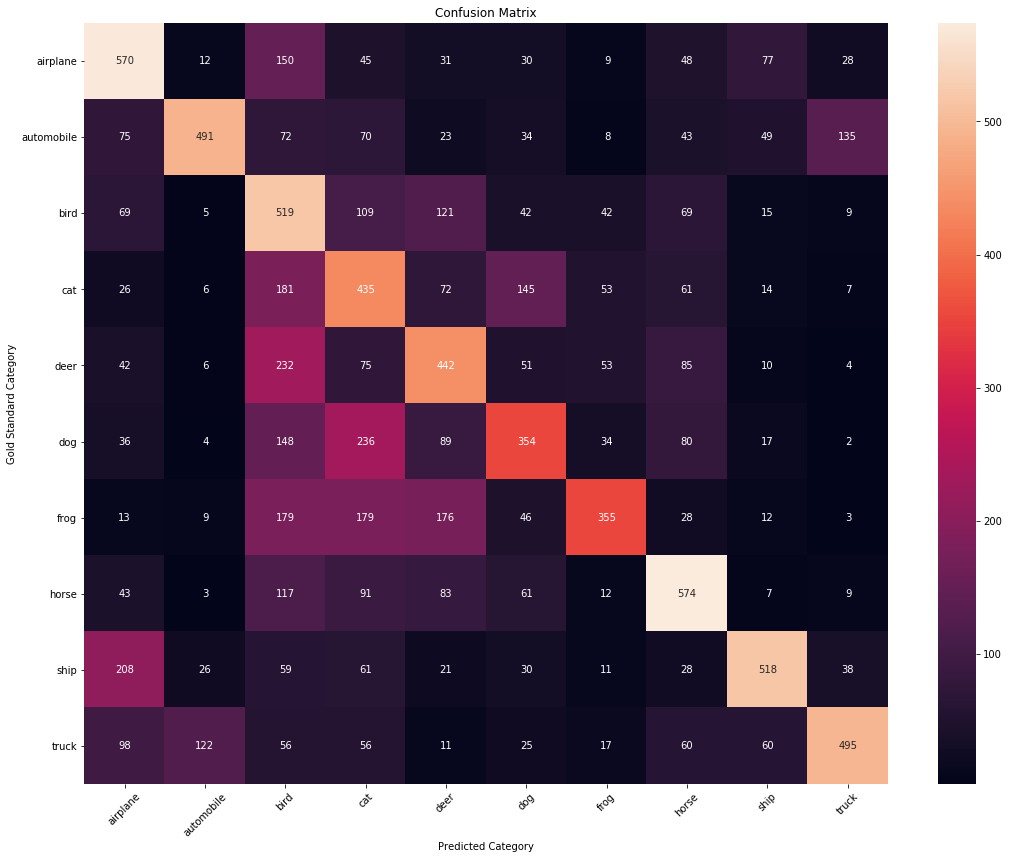

In [129]:
cf = confusion_matrix(single_test, mlp_single_pred)

# Plot the Confusion Matrix
df_cm = pd.DataFrame(cf, range(10), range(10))
sns.heatmap(df_cm, annot=True, 
            yticklabels=categories,  xticklabels=categories, cmap=None,
            fmt='2g')
plt.xticks(rotation=45)
plt.yticks(rotation='horizontal')
plt.ylabel('Gold Standard Category')
plt.xlabel('Predicted Category')
plt.title('Confusion Matrix')
plt.show()

In [130]:
errors = (single_test - mlp_single_pred != 0)

y_pred_classes_errors = mlp_single_pred[errors]
y_pred_errors = mlp_preds[errors]
y_test_errors = single_test[errors]
X_Test_errors = x_test2[errors]

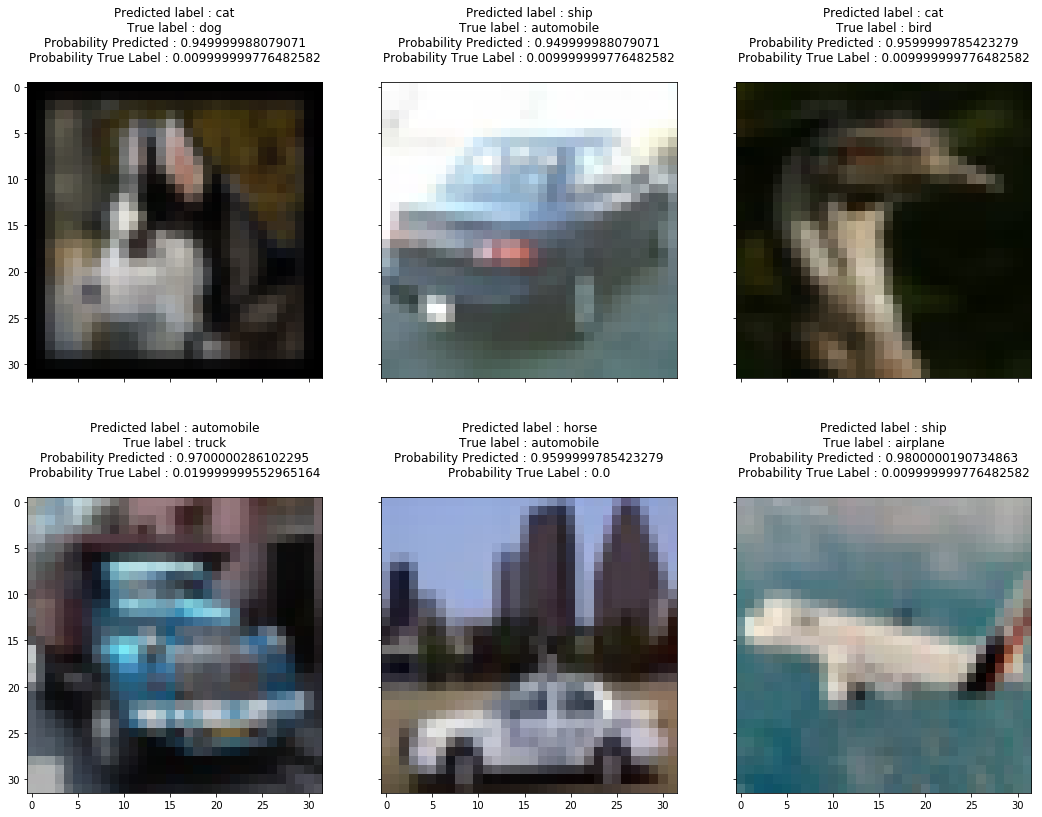

In [134]:
# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_test_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_Test_errors, y_pred_classes_errors, y_test_errors, y_pred_errors)

# 3. Convolutional Neural Network
##### Create a convolutional neural network with 3 convolutional layers, batch normalisation, dropout and max pooling.

In [25]:
# This model is definitely plagiarised, so will need to edit it somehow, I can do that tomorrow.

model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(32, activation='relu'))


model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_21 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_22 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [26]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.05,
    zoom_range=0.1
    )
datagen.fit(x_train)

In [27]:
#training

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=100,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[learning_rate_reduction])

Epoch 1/100
781/781 [==============================] - 18s 23ms/step - loss: 1.6040 - acc: 0.4330 - val_loss: 1.4180 - val_acc: 0.5312
Epoch 2/100
781/781 [==============================] - 16s 20ms/step - loss: 1.2355 - acc: 0.5766 - val_loss: 1.3294 - val_acc: 0.5785
Epoch 3/100
781/781 [==============================] - 15s 20ms/step - loss: 1.0949 - acc: 0.6305 - val_loss: 1.1007 - val_acc: 0.6401
Epoch 4/100
781/781 [==============================] - 15s 20ms/step - loss: 0.9858 - acc: 0.6746 - val_loss: 0.9537 - val_acc: 0.6926
Epoch 5/100
781/781 [==============================] - 16s 20ms/step - loss: 0.9268 - acc: 0.6975 - val_loss: 0.9617 - val_acc: 0.7029
Epoch 6/100
781/781 [==============================] - 16s 20ms/step - loss: 0.8778 - acc: 0.7205 - val_loss: 0.9056 - val_acc: 0.7203
Epoch 7/100
781/781 [==============================] - 15s 20ms/step - loss: 0.8473 - acc: 0.7339 - val_loss: 0.8158 - val_acc: 0.7534
Epoch 8/100
781/781 [==============================] - 

Epoch 58/100
781/781 [==============================] - 15s 19ms/step - loss: 0.4169 - acc: 0.8906 - val_loss: 0.4343 - val_acc: 0.8875
Epoch 59/100
781/781 [==============================] - 15s 19ms/step - loss: 0.4189 - acc: 0.8897 - val_loss: 0.4364 - val_acc: 0.8880

Epoch 00059: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 60/100
781/781 [==============================] - 15s 19ms/step - loss: 0.4188 - acc: 0.8873 - val_loss: 0.4327 - val_acc: 0.8884
Epoch 61/100
781/781 [==============================] - 15s 19ms/step - loss: 0.4169 - acc: 0.8889 - val_loss: 0.4308 - val_acc: 0.8887
Epoch 62/100
781/781 [==============================] - 15s 19ms/step - loss: 0.4156 - acc: 0.8907 - val_loss: 0.4312 - val_acc: 0.8886
Epoch 63/100
781/781 [==============================] - 15s 19ms/step - loss: 0.4152 - acc: 0.8891 - val_loss: 0.4370 - val_acc: 0.8877
Epoch 64/100
781/781 [==============================] - 15s 20ms/step - loss: 0.4185 - acc: 0.8882 - val_loss: 0.4302 -

In [135]:
cnn_preds = model.predict_proba(x_test)

cnn_single_pred = np.argmax(cnn_preds, axis=1)
single_test = np.argmax(y_test, axis=1)

### Classification Report
##### Display the types of errors made by the model for each class

In [136]:
print(classification_report(single_test, cnn_single_pred))

             precision    recall  f1-score   support

          0       0.92      0.91      0.91      1000
          1       0.93      0.95      0.94      1000
          2       0.89      0.84      0.86      1000
          3       0.84      0.73      0.78      1000
          4       0.87      0.88      0.88      1000
          5       0.88      0.79      0.83      1000
          6       0.82      0.97      0.89      1000
          7       0.93      0.94      0.94      1000
          8       0.95      0.94      0.95      1000
          9       0.89      0.96      0.92      1000

avg / total       0.89      0.89      0.89     10000



### Confusion Matrix
##### Plot a confusion matrix to show an overview of the error trends made by the model

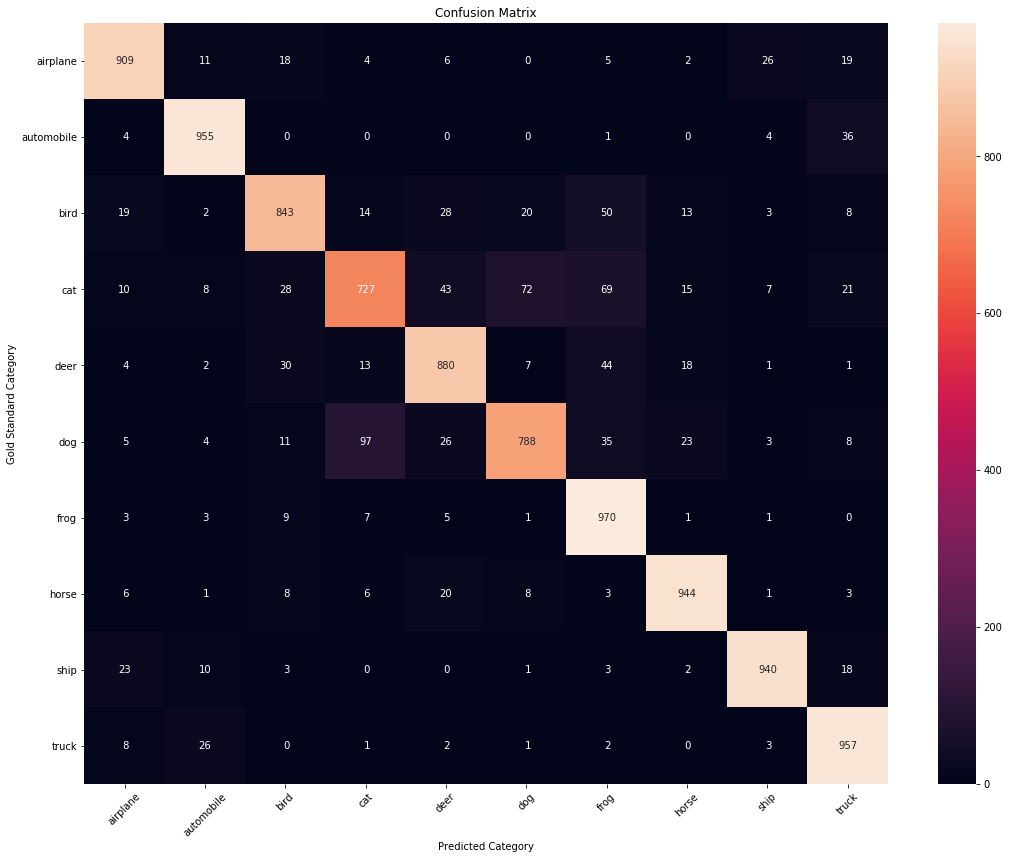

In [137]:
cf = confusion_matrix(single_test, cnn_single_pred)

# Plot the Confusion Matrix
df_cm = pd.DataFrame(cf, range(10), range(10))
sns.heatmap(df_cm, annot=True, 
            yticklabels=categories,  xticklabels=categories, cmap=None,
            fmt='2g')
plt.xticks(rotation=45)
plt.yticks(rotation='horizontal')
plt.ylabel('Gold Standard Category')
plt.xlabel('Predicted Category')
plt.title('Confusion Matrix')
plt.show()

In [154]:
errors = (single_test - cnn_single_pred != 0)

y_pred_classes_errors = cnn_single_pred[errors]
y_pred_errors = cnn_preds[errors]
y_test_errors = single_test[errors]
X_Test_errors = x_test2[errors]

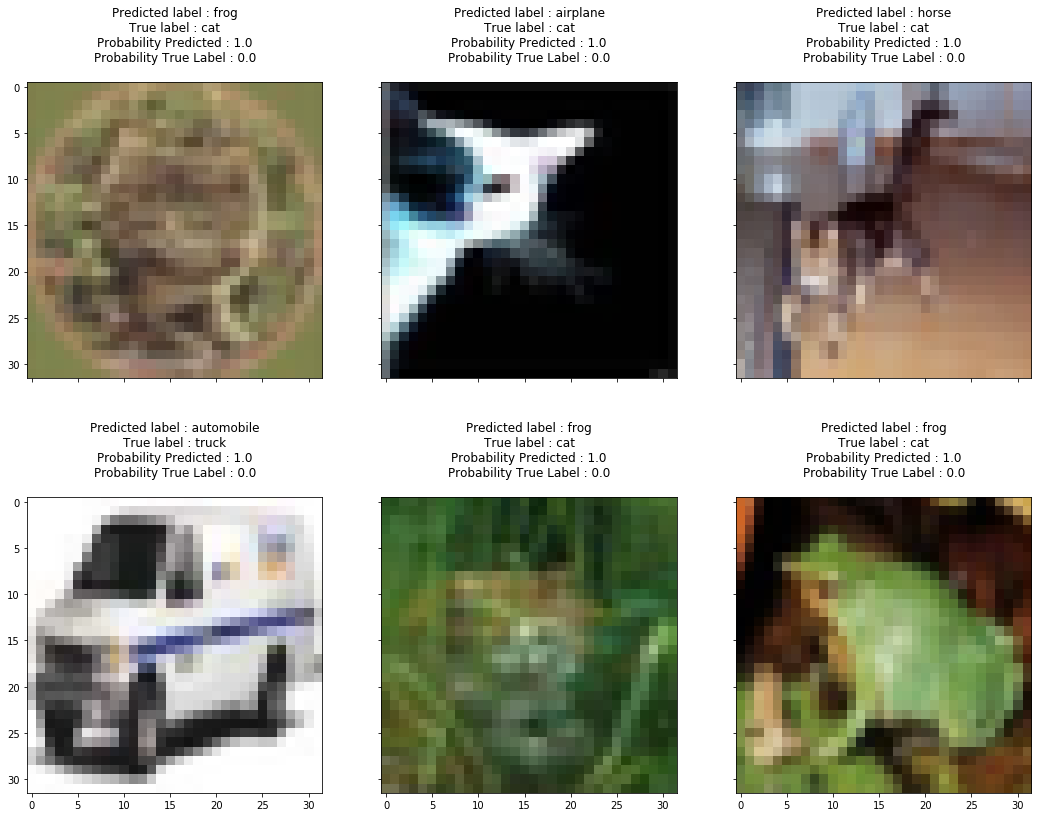

In [155]:
# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_test_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_Test_errors, y_pred_classes_errors, y_test_errors, y_pred_errors)